In [2]:
import numpy as np
import pandas as pd


import anndata
import scanpy as sc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

# kallisto
import kb_python
from kb_python.utils import import_matrix_as_anndata
from kb_python.constants import ADATA_PREFIX

def nd(matrix):
    return(np.array(matrix).flatten())

In [2]:
# load in adata object

counts_dir = f"./data/khateb/aligned/counts_unfiltered/"
u_barcodes_path=counts_dir+f"unspliced.barcodes.txt"
u_matrix_path=counts_dir+f"unspliced.mtx"
u_genes_path=counts_dir+"unspliced.genes.txt"

s_barcodes_path=counts_dir+f"spliced.barcodes.txt"
s_matrix_path=counts_dir+f"spliced.mtx"
s_genes_path=counts_dir+"spliced.genes.txt"

adata_u = import_matrix_as_anndata(u_matrix_path, u_barcodes_path, u_genes_path)
adata_u.layers['unspliced'] = adata_u.X
adata_s = import_matrix_as_anndata(s_matrix_path, s_barcodes_path, s_genes_path)
adata_s.layers['spliced'] = adata_s.X

/home/tara/.local/lib/python3.8/site-packages/kb_python/utils.py:641: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)
/home/tara/.local/lib/python3.8/site-packages/kb_python/utils.py:641: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)


In [3]:
def get_knee_plot(adata,layers,colors,title='Knee plot'):
    
    fs = 15

    fig,ax = plt.subplots(1,1,figsize=(7,7))

    for i,l in enumerate(layers):
        
        num_umi = np.array(adata.layers[l].sum(axis=1).flatten())[0]
        num_umi_sorted = np.sort(num_umi)[::-1]
        
        plt.scatter(num_umi_sorted,range(len(num_umi)),color=colors[i],s=3,
               edgecolors=None,label=l)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of UMIs',fontsize=fs)
    plt.ylabel('Barcode rank',fontsize=fs)
    plt.title(title,
               wrap=True,fontsize = fs)
    plt.legend(fontsize=fs)
    ax.grid()
    plt.show()

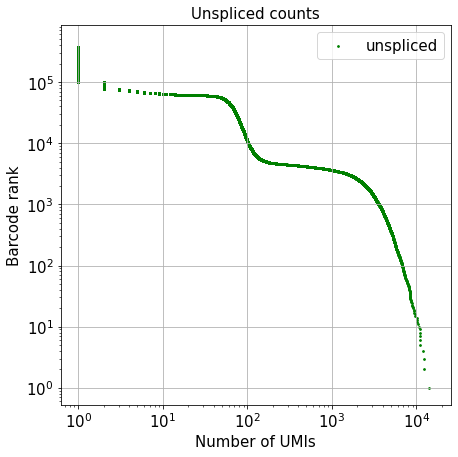

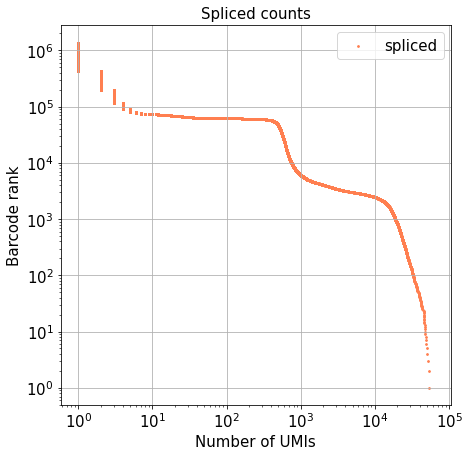

In [4]:
get_knee_plot(adata_u,layers=['unspliced'],colors=['green'],title='Unspliced counts')
get_knee_plot(adata_s,layers=['spliced'],colors=['coral'],title='Spliced counts');

In [5]:
# now create anndata object subsetting by cells that have both spliced/unspliced counts
adata_ = adata_u[adata_u.obs.index.isin(adata_s.obs.index)]
adata = adata_s[adata_s.obs.index.isin(adata_u.obs.index)]

adata.layers['spliced']  = adata.X
adata.layers['unspliced'] = adata_.X
adata.layers['sum'] = adata.X + adata_.X

# add gene id
adata.var['geneID'] = [g.split('.')[0] for g in  adata.var.index.values]

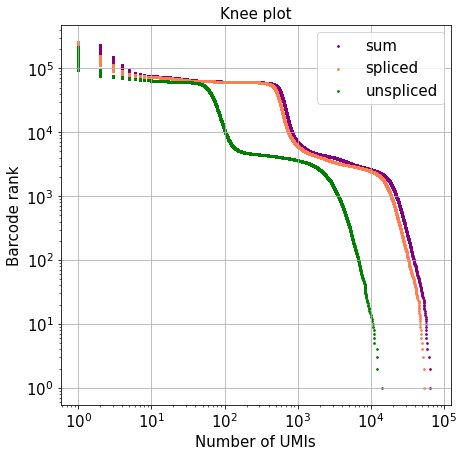

In [6]:
get_knee_plot(adata,layers=['sum','spliced','unspliced'],colors=['purple','coral','green'])

Text(0.5, 1.0, 'Total unspliced vs total spliced UMIs per gene')

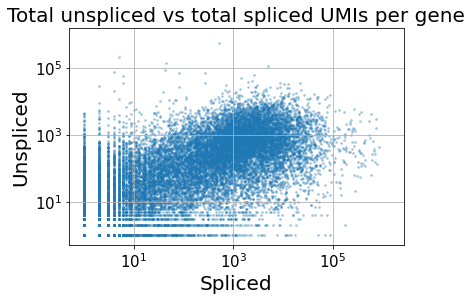

In [11]:
fs = 20
plt.scatter(nd(adata.layers['spliced'].sum(axis=0)),nd(adata.layers['unspliced'].sum(axis=0)),
           s = 3,alpha=0.3)
plt.xlabel('Spliced',fontsize=fs)
plt.ylabel('Unspliced',fontsize=fs)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('Total unspliced vs total spliced UMIs per gene',fontsize=fs)

Text(0.5, 1.0, 'Total unspliced vs total spliced UMIs per cell')

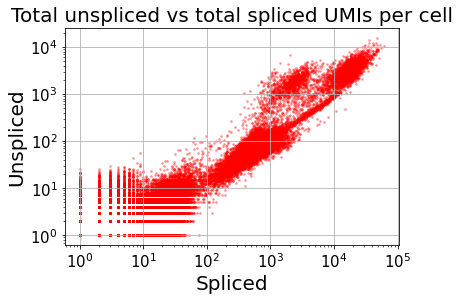

In [12]:
plt.scatter(nd(adata.layers['spliced'].sum(axis=1)),nd(adata.layers['unspliced'].sum(axis=1)),
           s = 3,alpha=0.3,color='red')
plt.xlabel('Spliced',fontsize=fs)
plt.ylabel('Unspliced',fontsize=fs)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('Total unspliced vs total spliced UMIs per cell',fontsize=fs)

In [56]:
# subset for cells with > 700 total UMIs
adata_subset = adata[adata.X.sum(axis=1)>700]

In [57]:
# write object
sc.tl.pca(adata_subset)

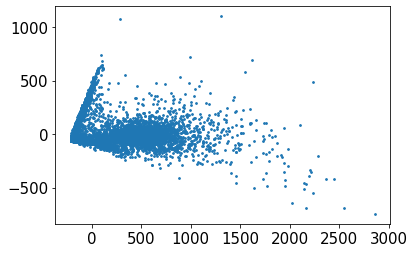

In [59]:
# plot top PCs
plt.scatter(adata_subset.obsm['X_pca'][:,0],adata_subset.obsm['X_pca'][:,1],s=3)

In [60]:
adata_subset.obs['cell_bc'] = adata_subset.obs.index
adata_subset.var['gene_id'] = adata_subset.var.index

In [61]:
gene_name_to_id_map = pd.read_csv('./data/takei/gene_id_to_name_map.csv')
gene_name_to_id_map['geneID'] = gene_name_to_id_map.ensembl_id_stripped.values

# subset for genes in takei study:
adata_subset = adata_subset[:,adata_subset.var.geneID.isin(gene_name_to_id_map.ensembl_id_stripped.values)]
adata_subset.var = adata_subset.var.merge(gene_name_to_id_map,on='geneID')

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [66]:
adata_subset.var['GENE_NAME'] = [g.upper() for g in adata_subset.var['gene_name'].values]

In [68]:
adata_subset.write_loom('./data/khateb/mESC.loom')

The loom file will lack these fields:
{'X_pca', 'PCs'}
Use write_obsm_varm=True to export multi-dimensional annotations


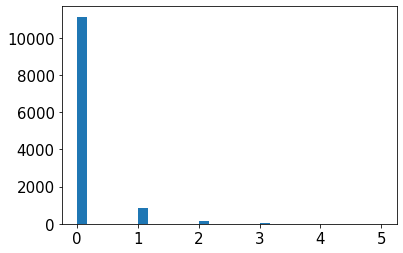

In [35]:
gene_ind = 200

plt.hist(np.array(adata_subset[:,gene_ind].X.todense()).flatten(),bins=30);

In [3]:
# read in object to see how many cells
adata_subset = anndata.read_loom('./data/khateb/mESC.loom')


# read in 

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
# read in search data object

!ls fits

battichODE		       mc_240226_026_khateb_1
gg_231127_026_rpe_1	       mc_240314_026_khateb_1
gg_240125_026_rpe_1	       mc_240513_026_germ_all_1
mc_240131_026_kozareva_f1_I_1  mc_240521_026_allen_B08_1
mc_240201_026_kozareva_f1_I_1  mc_240521_029_allen_B08_1
mc_240223_026_khateb_1	       mc_240530_026_germ_all_1
